<h1> Predicting State of Charge with Real Driving Cycles for Electric Vehicles</h1>

**Dataset**: https://www.kaggle.com/datasets/atechnohazard/battery-and-heating-data-in-real-driving-cycles </br>
**Dataset Description**: The data is split into a total of 72 files, one for each car trip. An extra "Overview" file contains weather information for the trip as well as general statistics, such as total duration. </br>
**Purpose**: The purpose of this notebook is to load, clean, preprocess, and determine important features for a dataset that includes dynamic weather conditions, real driving cycles, and battery data. </br>
**Scope**: Due to the limitation of available data, this dataset is limited towards using data that was gathered exclusively for the 2020 BMW I3 electric vehicle. As such, it's unlikely that the predictions made in this project would apply to other vehicles. Because of this, the project advisor and other group members decided to proceed with another dataset.

All code below are my own individual work contributions to the group project.

### 1: Import Libraries and Adjust Settings

In [68]:
# Pandas and numpy for data manipulation and organization
import pandas as pd
import numpy as np

# Remove column display limit
pd.set_option('display.max_columns', None)

# Import for plotting visualizations
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

# sklearn libraries for machine learning and feature importance
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve

### 2: Import Data

The combined dataset of all trips increases processing times exponentially when generating features. A single trip will be used to understand the cleaning process, generate features, and perform feature selection on. Then, all trips will be combined with the most important features.

In [2]:
# Importing test trip data
sample_df = pd.read_csv('TripA01.csv', delimiter = ";", encoding='latin1')

# Random sample of the trip data
sample_df.sample(5)

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],max. Battery Temperature [°C],SoC [%],displayed SoC [%],min. SoC [%],max. SoC [%),Heating Power CAN [kW],Heating Power LIN [W],Requested Heating Power [W],AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
4625,462.5,17.32,564.49,0.00,-78.08,-1.64,1.0,391.39,17.70,22.0,22.0,84.7,98.0,8,90,0.0,0,85,1.76,1,0,0,31.0,0,0,0,5.0,24.50
4412,441.2,36.85,565.63,37.30,8.20,0.05,0.0,388.34,-13.35,22.0,22.0,84.7,98.0,8,90,0.0,0,85,1.60,1,0,0,31.0,0,0,0,5.0,24.67
8464,846.4,0.00,564.11,0.00,0.00,0.53,0.0,388.20,-6.20,22.0,23.0,82.5,95.0,8,90,0.0,0,85,1.85,1,0,0,32.5,0,0,0,5.0,22.34
3582,358.2,26.71,570.05,39.24,5.50,-0.13,0.0,389.50,-10.59,22.0,22.0,85.2,98.5,8,90,0.0,0,85,1.71,1,0,0,31.0,0,0,0,5.0,25.01
4492,449.2,37.03,565.20,33.40,4.00,-0.18,0.0,388.74,-9.47,22.0,22.0,84.7,98.0,8,90,0.0,0,85,1.60,1,0,0,31.0,0,0,0,5.0,24.67


In [3]:
# Importing overview data
overview_df = pd.read_csv('Overview.csv')

# Random sample of the overview data
overview_df.sample(3)

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Unnamed: 8,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Unnamed: 13,Fan,Note
47,TripB16,2020-01-07_10-33-19,FTMRoute,slightly cloudy,11,13,67.50%,52.80%,14.70%,3.0,22.0,19.23,25.48,NaN,"Automatic, Level 1",FTMRoute (directly after previous trip)
65,TripB34,2020-01-14_12-55-08,Munich North,cloudy,11,11,73.90%,71.30%,2.60%,5.5,22.0,9.14,12.23,NaN,"Automatic, Level 1",+ 160 kg
6,TripA07,2019-07-01_12-59-48,Munich North,sunny,30,30,63.40%,34.20%,29.20%,33.5,25.0,44.34,34.89,NaN,"Automatic, Level 1",NaN


### 3: Data Preprocessing

#### Renaming Columns

Some columns contain a degrees symbol which should be removed.

In [20]:
def rename_columns(df):
    """
    df: The input dataframe
    
    Returns: Renamed columns for each trip dataframe 
    """
    df.rename(columns={'max. Battery Temperature [°C]': 'Max Battery Temperature [C]',
                   'Battery Temperature [°C]': 'Battery Temperature [C]',
                   'Coolant Temperature Heatercore [°C]': 'Coolant Temperature Heatercore [C]',
                   'Requested Coolant Temperature [°C]': 'Requested Coolant Temperature [C]',
                   'Coolant Temperature Inlet [°C]': 'Coolant Temperature Inlet [C]',
                   'Heat Exchanger Temperature [°C]': 'Heat Exchanger Temperature [C]',
                   'Ambient Temperature [°C]': 'Ambient Temperature [C]',
                   'Cabin Temperature Sensor [°C]': 'Cabin Temperature Sensor [C]'}, inplace=True)
    
    return df

In [21]:
sample_df = rename_columns(sample_df)

#### Grouping Weather Categories

There are too many weather categories with not enough representation in the data. They can be grouped into similar categories.

In [22]:
overview_df["Weather"].value_counts()

sunny     46
cloudy    13
dark       8
rainy      3
Name: Weather, dtype: int64

Categories changed</br>
Remove sunrise and sunset, add to dark</br>
Remove "dark little rainy", add to rainy</br>
Remove slightly cloudy, add to sunny

In [23]:
# Replace the categories according to above
overview_df["Weather"].replace({"sunrise": "dark", "dark, little rainy": "rainy", "sunset": "dark", "slightly cloudy": "sunny"}, inplace=True)

overview_df["Weather"].value_counts()

sunny     46
cloudy    13
dark       8
rainy      3
Name: Weather, dtype: int64

### 4. Feature Generation

The goal of feature generation is to capture the time-series nature of the data by creating moving averages and changes over time within the data. This section would take too long to complete using the whole dataset, so using a single trip to determine feature importance is neccessary.

After these features are generated, a handful of the most important features will be decided using decision trees.

In [26]:
def feature_generation(df):
    """
    df: The input trip data dataframe
    
    Returns: A dataframe with additional generated columns from the input data
    """
    
    # Moving Averages for Battery Voltage [V]
    df['5MA Voltage'] = df["Battery Voltage [V]"].rolling(window=5).mean()
    df['10MA Voltage'] = df["Battery Voltage [V]"].rolling(window=10).mean()
    df['20MA Voltage'] = df["Battery Voltage [V]"].rolling(window=20).mean()
    df['40MA Voltage'] = df["Battery Voltage [V]"].rolling(window=40).mean()
    df['60MA Voltage'] = df["Battery Voltage [V]"].rolling(window=60).mean()
    
    df['5EMA Voltage'] = df['Battery Voltage [V]'].ewm(span=5, adjust=False).mean()
    df['10EMA Voltage'] = df['Battery Voltage [V]'].ewm(span=10, adjust=False).mean()
    df['20EMA Voltage'] = df['Battery Voltage [V]'].ewm(span=20, adjust=False).mean()
    df['40EMA Voltage'] = df['Battery Voltage [V]'].ewm(span=40, adjust=False).mean()
    df['60EMA Voltage'] = df['Battery Voltage [V]'].ewm(span=60, adjust=False).mean()
    
    # Moving Averages for Longitudinal Acceleration [m/s^2]
    df['5MA Acceleration'] = df["Longitudinal Acceleration [m/s^2]"].rolling(window=5).mean()
    df['10MA Acceleration'] = df["Longitudinal Acceleration [m/s^2]"].rolling(window=10).mean()
    df['20MA Acceleration'] = df["Longitudinal Acceleration [m/s^2]"].rolling(window=20).mean()
    df['40MA Acceleration'] = df["Longitudinal Acceleration [m/s^2]"].rolling(window=40).mean()
    df['60MA Acceleration'] = df["Longitudinal Acceleration [m/s^2]"].rolling(window=60).mean()
    
    df['5EMA Acceleration'] = df['Longitudinal Acceleration [m/s^2]'].ewm(span=5, adjust=False).mean()
    df['10EMA Acceleration'] = df['Longitudinal Acceleration [m/s^2]'].ewm(span=10, adjust=False).mean()
    df['20EMA Acceleration'] = df['Longitudinal Acceleration [m/s^2]'].ewm(span=20, adjust=False).mean()
    df['40EMA Acceleration'] = df['Longitudinal Acceleration [m/s^2]'].ewm(span=40, adjust=False).mean()
    df['60EMA Acceleration'] = df['Longitudinal Acceleration [m/s^2]'].ewm(span=60, adjust=False).mean()
    
    # Moving Averages for Velocity [km/h]
    df['5MA Velocity'] = df["Velocity [km/h]"].rolling(window=5).mean()
    df['10MA Velocity'] = df["Velocity [km/h]"].rolling(window=10).mean()
    df['20MA Velocity'] = df["Velocity [km/h]"].rolling(window=20).mean()
    df['40MA Velocity'] = df["Velocity [km/h]"].rolling(window=40).mean()
    df['60MA Velocity'] = df["Velocity [km/h]"].rolling(window=60).mean()
    
    df['5EMA Velocity'] = df['Velocity [km/h]'].ewm(span=5, adjust=False).mean()
    df['10EMA Velocity'] = df['Velocity [km/h]'].ewm(span=10, adjust=False).mean()
    df['20EMA Velocity'] = df['Velocity [km/h]'].ewm(span=20, adjust=False).mean()
    df['40EMA Velocity'] = df['Velocity [km/h]'].ewm(span=40, adjust=False).mean()
    df['60EMA Velocity'] = df['Velocity [km/h]'].ewm(span=60, adjust=False).mean()
    
    # Moving Averages for Battery Current [A]
    df['5MA Battery Current'] = df["Battery Current [A]"].rolling(window=5).mean()
    df['10MA Battery Current'] = df["Battery Current [A]"].rolling(window=10).mean()
    df['20MA Battery Current'] = df["Battery Current [A]"].rolling(window=20).mean()
    df['40MA Battery Current'] = df["Battery Current [A]"].rolling(window=40).mean()
    df['60MA Battery Current'] = df["Battery Current [A]"].rolling(window=60).mean()
    
    df['5EMA Battery Current'] = df['Battery Current [A]'].ewm(span=5, adjust=False).mean()
    df['10EMA Battery Current'] = df['Battery Current [A]'].ewm(span=10, adjust=False).mean()
    df['20EMA Battery Current'] = df['Battery Current [A]'].ewm(span=20, adjust=False).mean()
    df['40EMA Battery Current'] = df['Battery Current [A]'].ewm(span=40, adjust=False).mean()
    df['60EMA Battery Current'] = df['Battery Current [A]'].ewm(span=60, adjust=False).mean()

    ### % Change from X rows ago for just current and voltage
    # 1 Row Ago
    voltage_list = [0] * 1
    elevation_list = [0] * 1
    for i in range(1, df.shape[0]):
        voltage_list.append(((df['Battery Voltage [V]'].iloc[i - 1] - df['Battery Voltage [V]'].iloc[i])/ (df['Battery Voltage [V]'].iloc[i] + .000000000001))*100)
        elevation_list.append(((df['Elevation [m]'].iloc[i - 1] - df['Elevation [m]'].iloc[i])/ (df['Elevation [m]'].iloc[i] + .000000000001))*100)
    df['Voltage %Change by 1'] = voltage_list
    df['Elevation %Change by 1'] = elevation_list
    
    # 7 Row Ago
    voltage_list = [0] * 7
    elevation_list = [0] * 7
    for i in range(7, df.shape[0]):
        voltage_list.append(((df['Battery Voltage [V]'].iloc[i - 7] - df['Battery Voltage [V]'].iloc[i])/ (df['Battery Voltage [V]'].iloc[i] + .000000000001))*100)
        elevation_list.append(((df['Elevation [m]'].iloc[i - 7] - df['Elevation [m]'].iloc[i])/ (df['Elevation [m]'].iloc[i] + .000000000001))*100)
    df['Voltage %Change by 7'] = voltage_list
    df['Elevation %Change by 7'] = elevation_list
    
    # 15 Row Ago
    voltage_list = [0] * 15
    elevation_list = [0] * 15
    for i in range(15, df.shape[0]):
        voltage_list.append(((df['Battery Voltage [V]'].iloc[i - 15] - df['Battery Voltage [V]'].iloc[i])/ (df['Battery Voltage [V]'].iloc[i] + .000000000001))*100)
        elevation_list.append(((df['Elevation [m]'].iloc[i - 15] - df['Elevation [m]'].iloc[i])/ (df['Elevation [m]'].iloc[i] + .000000000001))*100)
    df['Voltage %Change by 15'] = voltage_list
    df['Elevation %Change by 15'] = elevation_list
    
    # Calculating Distance Travelled
    distance_list = [0] * 1
    for i in range(1, df.shape[0]):
        distance_list.append(df['Velocity [km/h]'].iloc[i]/36000 + distance_list[i - 1])
    df['Distance Covered'] = distance_list

    return df

### 5. Data Integration

In [44]:
# Empty file names list for iterative processing
file_names = []

for i in range(1, 10):
    file_names.append("TripA0" + str(i) + ".csv")
    
for i in range(10, 33):
    file_names.append("TripA" + str(i) + ".csv")
    
for i in range(1, 10):
    file_names.append("TripB0" + str(i) + ".csv")
    
for i in range(10, 39):
    file_names.append("TripB" + str(i) + ".csv")

In [49]:
# Empty dataframe
df = pd.DataFrame({})

for i in range(0,len(file_names)):
    # Read csv with latin1 encoding for the special degrees symbol in the files
    temp_df = pd.read_csv(file_names[i], delimiter = ";", encoding='latin1')
    
    # Apply rename columns function
    temp_df = rename_columns(temp_df)

    # Apply feature generation to individual files
    temp_df = feature_generation(temp_df)
    
    # Add weather column depending on the overview file
    temp_df['Weather'] = overview_df.iloc[i][3]
    
    # Append to the main dataframe
    df = df.append(temp_df, ignore_index=True)

    
# Apply one-hot encoding to convert categorical values of weather into numerical ones with multiple columns
one_hot = pd.get_dummies(df["Weather"], prefix='Weather')
df = df.join(one_hot)

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [C],Max Battery Temperature [C],SoC [%],displayed SoC [%],min. SoC [%],max. SoC [%),Heating Power CAN [kW],Heating Power LIN [W],Requested Heating Power [W],AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [C],Coolant Temperature Heatercore [C],Requested Coolant Temperature [C],Coolant Temperature Inlet [C],Heat Exchanger Temperature [C],Cabin Temperature Sensor [C],5MA Voltage,10MA Voltage,20MA Voltage,40MA Voltage,60MA Voltage,5EMA Voltage,10EMA Voltage,20EMA Voltage,40EMA Voltage,60EMA Voltage,5MA Acceleration,10MA Acceleration,20MA Acceleration,40MA Acceleration,60MA Acceleration,5EMA Acceleration,10EMA Acceleration,20EMA Acceleration,40EMA Acceleration,60EMA Acceleration,5MA Velocity,10MA Velocity,20MA Velocity,40MA Velocity,60MA Velocity,5EMA Velocity,10EMA Velocity,20EMA Velocity,40EMA Velocity,60EMA Velocity,5MA Battery Current,10MA Battery Current,20MA Battery Current,40MA Battery Current,60MA Battery Current,5EMA Battery Current,10EMA Battery Current,20EMA Battery Current,40EMA Battery Current,60EMA Battery Current,Voltage %Change by 1,Elevation %Change by 1,Voltage %Change by 7,Elevation %Change by 7,Voltage %Change by 15,Elevation %Change by 15,Distance Covered,Weather,Unnamed: 23,Ambient Temperature Sensor [°C],Coolant Volume Flow +500 [l/h],Temperature Coolant Heater Inlet [°C],Temperature Coolant Heater Outlet [°C],Temperature Heat Exchanger Outlet [°C],Temperature Defrost lateral left [°C],Temperature Defrost lateral right [°C],Temperature Defrost central [°C],Temperature Defrost central left [°C],Temperature Defrost central right [°C],Temperature Footweel Driver [°C],Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C],Weather_cloudy,Weather_dark,Weather_rainy,Weather_sunny
168139,626.5,97.77,599.13,0.0,36.5,0.34,0.0,380.16,-81.49,28.0,29.0,80.4,93.5,8.0,90.0,0.0,NaN,0.0,0.78,1,NaN,NaN,27.0,NaN,85.0,NaN,5.0,30.67,380.192,380.196,380.2175,380.33925,380.6065,380.186912,380.197165,380.237812,380.418801,380.650021,0.392,0.374,0.3835,0.37925,0.365,0.373829,0.376742,0.379226,0.370935,0.352873,97.702,97.646,97.6155,97.48,97.412167,97.70869,97.668358,97.610414,97.524893,97.477161,-81.484,-81.424,-81.539,-80.987,-78.1,-81.461716,-81.470569,-81.336339,-79.724789,-77.278226,0.010522,-0.003338,0.010522,-0.021698,0.036827,-0.048404,8.345714,sunny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1


In [50]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [C],Max Battery Temperature [C],SoC [%],displayed SoC [%],min. SoC [%],max. SoC [%),Heating Power CAN [kW],Heating Power LIN [W],Requested Heating Power [W],AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [C],Coolant Temperature Heatercore [C],Requested Coolant Temperature [C],Coolant Temperature Inlet [C],Heat Exchanger Temperature [C],Cabin Temperature Sensor [C],5MA Voltage,10MA Voltage,20MA Voltage,40MA Voltage,60MA Voltage,5EMA Voltage,10EMA Voltage,20EMA Voltage,40EMA Voltage,60EMA Voltage,5MA Acceleration,10MA Acceleration,20MA Acceleration,40MA Acceleration,60MA Acceleration,5EMA Acceleration,10EMA Acceleration,20EMA Acceleration,40EMA Acceleration,60EMA Acceleration,5MA Velocity,10MA Velocity,20MA Velocity,40MA Velocity,60MA Velocity,5EMA Velocity,10EMA Velocity,20EMA Velocity,40EMA Velocity,60EMA Velocity,5MA Battery Current,10MA Battery Current,20MA Battery Current,40MA Battery Current,60MA Battery Current,5EMA Battery Current,10EMA Battery Current,20EMA Battery Current,40EMA Battery Current,60EMA Battery Current,Voltage %Change by 1,Elevation %Change by 1,Voltage %Change by 7,Elevation %Change by 7,Voltage %Change by 15,Elevation %Change by 15,Distance Covered,Unnamed: 23,Ambient Temperature Sensor [°C],Coolant Volume Flow +500 [l/h],Temperature Coolant Heater Inlet [°C],Temperature Coolant Heater Outlet [°C],Temperature Heat Exchanger Outlet [°C],Temperature Defrost lateral left [°C],Temperature Defrost lateral right [°C],Temperature Defrost central [°C],Temperature Defrost central left [°C],Temperature Defrost central right [°C],Temperature Footweel Driver [°C],Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C],Weather_cloudy,Weather_dark,Weather_rainy,Weather_sunny
count,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1064000.00,1063999.00,1064000.00,1063999.00,1094793.00,784206.00,1094793.00,1094793.00,1094793.00,784206.00,784206.00,1094793.00,784206.00,1074964.00,784206.00,1094793.00,1094793.00,1094513.00,1094163.00,1093463.00,1092063.00,1090663.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094513.00,1094163.00,1093463.00,1092063.00,1090663.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094513.00,1094163.00,1093463.00,1092063.00,1090663.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094513.00,1094163.00,1093463.00,1092063.00,1090663.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1094793.00,1.00,622453.00,598759.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,622453.00,1094793.00,1094793.00,1094793.00,1094793.00
mean,1030.38,44.65,532.21,28.08,10.77,-0.00,0.05,376.38,-17.30,15.42,16.04,65.10,74.16,8.00,89.11,1.22,1364.21,1183.41,0.16,0.92,372.73,3.64,13.06,46.73,81.51,45.94,28.97,23.96,376.38,376.38,376.37,376.37,376.36,376.38,376.38,376.38,376.39,376.39,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,44.66,44.67,44.70,44.75,44.81,44.65,44.65,44.65,44.65,44.64,-17.31,-17.31,-17.32,-17.33,-17.35,-17.30,-17.30,-17.31,-17.31,-17.31,0.00,-0.00,0.00,-0.00,0.01,-0.00,12.90,43650.00,6.14,-15.72,47.77,50.54,48.34,29.77,30.03,33.69,33.36,31.56,19.66,23.53,40.69,40.04,19.10,20.59,31.07,30.19,32.30,28.99,0.21,0.09,0.05,0.66
std,894.87,35.36,45.28,18.76,34.80,0.63,0.22,11.86,44.44,7.43,7.49,15.11,19.49,0.01,0.63,1.76,1694.24,1783.29,0.37

### 6. Data Cleaning

In [53]:
# Count all null values in all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.isna().sum())

Time [s]                                        0
Velocity [km/h]                                 0
Elevation [m]                                   0
Throttle [%]                                    0
Motor Torque [Nm]                               0
Longitudinal Acceleration [m/s^2]               0
Regenerative Braking Signal                     0
Battery Voltage [V]                             0
Battery Current [A]                             0
Battery Temperature [C]                         0
Max Battery Temperature [C]                     0
SoC [%]                                     30793
displayed SoC [%]                           30794
min. SoC [%]                                30793
max. SoC [%)                                30794
Heating Power CAN [kW]                          0
Heating Power LIN [W]                      310587
Requested Heating Power [W]                     0
AirCon Power [kW]                               0
Heater Signal                                   0


**Null Value Explanations**</br>
- Columns with 472340 or 310587 missing values are only present in half of the trips and will be dropped
- Missing values from moving averages are from incalculable values, the missing rows will be removed. This should not affect the analysis too much as only the first ~5 minutes will be dropped.
- One trip has missing SoC values and those rows needs to be removed as that is our target variable

In [60]:
drop_column_list = ["Unnamed: 23",
            "Temperature Coolant Heater Inlet [°C]",
            "Temperature Coolant Heater Outlet [°C]",
            "Temperature Heat Exchanger Outlet [°C]",
            "Temperature Defrost lateral left [°C]",
            "Temperature Defrost lateral right [°C]",
            "Temperature Defrost central [°C]",
            "Temperature Defrost central left [°C]",
            "Temperature Defrost central right [°C]",
            "Temperature Footweel Driver [°C]",
            "Temperature Footweel Co-Driver [°C]",
            "Temperature Feetvent Co-Driver [°C]",
            "Temperature Feetvent Driver [°C]",
            "Temperature Head Co-Driver [°C]",
            "Temperature Head Driver [°C]",
            "Temperature Vent right [°C]",
            "Temperature Vent central right [°C]",
            "Temperature Vent central left [°C]",
            "Temperature Vent right [°C]",
            "Ambient Temperature Sensor [°C]",
            "Coolant Volume Flow +500 [l/h]",
            "Heating Power LIN [W]",
            "Heater Voltage [V]",
            "Heater Current [A]",
            "Coolant Temperature Inlet [C]",
            "Coolant Temperature Heatercore [C]",
            "Requested Coolant Temperature [C]"]

In [74]:
# Drop each column in drop_column_list
clean_df = df.drop(drop_column_list, axis=1)

# To remove Temperature Vent right [�C], that doesn't drop for some reason
clean_df = clean_df.drop(clean_df.columns[len(clean_df.columns)-5], axis=1)

In [75]:
# Additional columns to drop as these have same values throughout or would not contribute to analysis
drop_column_list2 = ["min. SoC [%]", 
                     "max. SoC [%)", 
                     "displayed SoC [%]", 
                     "Requested Heating Power [W]",
                     "Longitudinal Acceleration [m/s^2]",
                     "Weather"]

clean_df = clean_df.drop(drop_column_list2, axis=1)

In [76]:
# Removing rows with zero values from moving averages and missing state of charge 
clean_df = clean_df.dropna()

In [77]:
# Check if all null values are removed
print(f"The number of null values in df is {clean_df.isna().sum().sum()}")

The number of null values in df is 0


In [78]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
clean_df.describe()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [C],Max Battery Temperature [C],SoC [%],Heating Power CAN [kW],AirCon Power [kW],Heater Signal,Ambient Temperature [C],Heat Exchanger Temperature [C],Cabin Temperature Sensor [C],5MA Voltage,10MA Voltage,20MA Voltage,40MA Voltage,60MA Voltage,5EMA Voltage,10EMA Voltage,20EMA Voltage,40EMA Voltage,60EMA Voltage,5MA Acceleration,10MA Acceleration,20MA Acceleration,40MA Acceleration,60MA Acceleration,5EMA Acceleration,10EMA Acceleration,20EMA Acceleration,40EMA Acceleration,60EMA Acceleration,5MA Velocity,10MA Velocity,20MA Velocity,40MA Velocity,60MA Velocity,5EMA Velocity,10EMA Velocity,20EMA Velocity,40EMA Velocity,60EMA Velocity,5MA Battery Current,10MA Battery Current,20MA Battery Current,40MA Battery Current,60MA Battery Current,5EMA Battery Current,10EMA Battery Current,20EMA Battery Current,40EMA Battery Current,60EMA Battery Current,Voltage %Change by 1,Elevation %Change by 1,Voltage %Change by 7,Elevation %Change by 7,Voltage %Change by 15,Elevation %Change by 15,Distance Covered,Weather_cloudy,Weather_dark,Weather_rainy,Weather_sunny
count,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00
mean,963.15,45.66,530.06,28.68,11.01,0.05,376.18,-19.47,15.50,16.09,65.07,1.24,0.17,0.92,13.22,28.90,23.97,376.18,376.18,376.18,376.19,376.19,376.18,376.18,376.18,376.19,376.19,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,45.66,45.66,45.66,45.66,45.66,45.66,45.66,45.66,45.66,45.66,-19.47,-19.47,-19.48,-19.48,-19.49,-19.47,-19.47,-19.48,-19.48,-19.49,0.00,-0.00,0.00,-0.00,0.01,-0.00,12.11,0.21,0.09,0.05,0.65
std,749.27,35.20,42.31,18.50,35.23,0.22,11.80,42.33,7.51,7.57,15.11,1.78,0.37,0.27,9.70,16.04,4.88,11.80,11.78,11.73,11.63,11.54,11.79,11.75,11.68,11.56,11.48,0.63,0.62,0.59,0.53,0.49,0.62,0.60,0.57,0.50,0.45,35.19,35.19,35.17,35.12,35.04,35.19,35.18,35.14,35.02,34.89,42.16,41.73,40.55,38.10,36.02,41.92,41.12,39.43,36.62,34.54,0.08,0.01,0.48,0.02,0.85,0.03,11.59,0.41,0.29,0.23,0.48
min,5.90,0.00,437.00,0.00,-87.90,0.00,301.80,-404.38,-1.00,-1.00,0.00,0.00,-0.17,0.00,-3.50,5.00,10.00,301.83,301.93,302.18,303.10,303.61,301.88,302.01,302.76,304.37,305.39,-8.02,-6.02,-5.46,-3.52,-2.84,-7.41,-5.86,-4.74,-3.69,-3.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-401.00,-398.76,-397.38,-379.95,-362.27,-398.84,-394.23,-376.77,-340.25,-315.23,-4.43,-5.75,-9.35,-5.76,-11.91,-5.78,0.00,0.00,0.00,0.00,0.00
25%,386.20,16.74,487.00,12.78,0.00,0.00,369.00,-32.18,9.00,10.00,56.40,0.00,0.00,1.00,5.00,12.00,22.67,369.00,369.01,369.02,369.01,369.00,369.00,369.01,369.03,369.01,369.00,-0.24,-0.24,-0.24,-0.23,-0.22,-0.24,-0.24,-0.23,-0.22,-0.21,16.74,16.75,16.75,16.78,16.90,16.74,16.76,16.80,16.95,17.17,-32.25,-32.40,-32.63,-32.56,-32.06,-32.34,-32.51,-32.54,-32.13,-31.59,-0.01,0.00,-0.08,-0.00,-0.18,-0.01,3.31,0.00,0.00,0.00,0.00
50%,796.60,41.74,529.63,33.73,7.00,0.00,379.26,-11.91,15.00,16.00,68.20,0.96,0.00,1.00,9.50,35.00,24.17,379.25,379.25,379.25,379.23,379.22,379.25,379.25,379.24,379.23,379.22,-0.02,-0.02,-0.01,-0.01,-0.00,-0.02,-0.02,-0.01,-0.00,-0.00,41.73,41.72,41.68,41.57,41.43,41.73,41.70,41.63,41.44,41.20,-11.93,-11.98,-12.15,-12.64,-13.08,-11.96,-12.08,-12.37,-12.86,-13.23,0.00,0

### 7. Feature Importance

#### Data Normalization

Prior to feature importance steps, data normalization should be applied to the dataset to prevent any influence on importance due to the scaling of the columns.

In [79]:
# Create a variable that has all the column names
norm_columns = list(clean_df.columns)

# Remove binary columns as they do not require normalization
norm_columns.remove("Regenerative Braking Signal ")
norm_columns.remove("Heater Signal")
norm_columns.remove("Weather_cloudy")
norm_columns.remove("Weather_dark")
norm_columns.remove("Weather_rainy")
norm_columns.remove("Weather_sunny")

In [81]:
# Create a copy of the cleaned data frame
norm_df = clean_df.copy()

# For every column that is in the norm_columns, normalize the column
for col in norm_columns:
    norm_df[col] = (norm_df[col] - norm_df[col].min()) / (norm_df[col].max() - norm_df[col].min())

In [82]:
# Summary statistics of the normalized data to ensure normalization was completed correctly
norm_df.describe()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [C],Max Battery Temperature [C],SoC [%],Heating Power CAN [kW],AirCon Power [kW],Heater Signal,Ambient Temperature [C],Heat Exchanger Temperature [C],Cabin Temperature Sensor [C],5MA Voltage,10MA Voltage,20MA Voltage,40MA Voltage,60MA Voltage,5EMA Voltage,10EMA Voltage,20EMA Voltage,40EMA Voltage,60EMA Voltage,5MA Acceleration,10MA Acceleration,20MA Acceleration,40MA Acceleration,60MA Acceleration,5EMA Acceleration,10EMA Acceleration,20EMA Acceleration,40EMA Acceleration,60EMA Acceleration,5MA Velocity,10MA Velocity,20MA Velocity,40MA Velocity,60MA Velocity,5EMA Velocity,10EMA Velocity,20EMA Velocity,40EMA Velocity,60EMA Velocity,5MA Battery Current,10MA Battery Current,20MA Battery Current,40MA Battery Current,60MA Battery Current,5EMA Battery Current,10EMA Battery Current,20EMA Battery Current,40EMA Battery Current,60EMA Battery Current,Voltage %Change by 1,Elevation %Change by 1,Voltage %Change by 7,Elevation %Change by 7,Voltage %Change by 15,Elevation %Change by 15,Distance Covered,Weather_cloudy,Weather_dark,Weather_rainy,Weather_sunny
count,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00,1059871.00
mean,0.25,0.30,0.41,0.21,0.29,0.05,0.80,0.70,0.50,0.50,0.74,0.03,0.10,0.92,0.45,0.40,0.47,0.80,0.80,0.81,0.81,0.81,0.80,0.81,0.81,0.81,0.81,0.65,0.59,0.57,0.46,0.47,0.63,0.58,0.54,0.50,0.48,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.70,0.70,0.70,0.69,0.68,0.70,0.70,0.69,0.67,0.66,0.58,0.94,0.43,0.94,0.46,0.95,0.20,0.21,0.09,0.05,0.65
std,0.20,0.23,0.19,0.14,0.10,0.22,0.13,0.08,0.23,0.22,0.17,0.04,0.11,0.27,0.26,0.27,0.16,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.05,0.06,0.06,0.07,0.08,0.05,0.06,0.06,0.07,0.07,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.08,0.08,0.08,0.07,0.07,0.08,0.08,0.08,0.08,0.08,0.01,0.00,0.02,0.00,0.03,0.00,0.19,0.41,0.29,0.23,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.10,0.11,0.22,0.09,0.26,0.00,0.72,0.68,0.30,0.32,0.64,0.00,0.05,1.00,0.23,0.12,0.42,0.72,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.63,0.57,0.54,0.43,0.43,0.61,0.56,0.51,0.47,0.45,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.68,0.68,0.68,0.67,0.66,0.68,0.68,0.67,0.65,0.63,0.58,0.94,0.43,0.94,0.45,0.94,0.05,0.00,0.00,0.00,0.00
50%,0.21,0.27,0.41,0.25,0.28,0.00,0.83,0.72,0.48,0.50,0.77,0.02,0.05,1.00,0.35,0.50,0.47,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.65,0.59,0.57,0.46,0.46,0.63,0.58,0.54,0.50,0.48,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.72,0.72,0.72,0.71,0.70,0.72,0.71,0.71,0.69,0.68,0.58,0.94,0.43,0.94,0.46,0.95,0.16,0.00,0.00,0.00,1.00
75%,0.35,0.45,0.56,0.32,0.33,0.00,0.90,0.73,0.67,0.68,0.86,0.04,0.11,1.00,0.69,0.61,0.53,0.90,0.90,0.90,0.90,0.91,0.90,0.90,0.90,0.91,0.91,0.67,0.61,0.59,0.49,0.50,0.65,0.60,0.56,0.53,0.51,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.74,0.74,0.74,0.73,0.72,0.73,0.73,0.73,0.71,0.70,0.59,0.94,0.43,0.94

#### Feature Importance

In [95]:
# The target variable will be set to SoC [%]
y = norm_df["SoC [%]"]
y = y.to_numpy()
X = norm_df.drop(columns=["SoC [%]"], axis=1)

# Split the dataset into a 80% training and 20% testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 21)

#### Linear Feature Importance

In [96]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

                           feature  importance
24                   40EMA Voltage  -57.737015
53           20EMA Battery Current  -54.759524
44                  40EMA Velocity  -41.929888
22                   10EMA Voltage  -28.877308
55           60EMA Battery Current  -24.945968
42                  10EMA Velocity  -21.316422
51            5EMA Battery Current   -8.703277
33              20EMA Acceleration   -6.213580
50            60MA Battery Current   -3.788516
49            40MA Battery Current   -2.685677
38                   20MA Velocity   -2.032459
47            10MA Battery Current   -1.978537
35              60EMA Acceleration   -1.520512
18                    20MA Voltage   -1.259164
46             5MA Battery Current   -0.930315
30               60MA Acceleration   -0.856620
31               5EMA Acceleration   -0.555721
29               40MA Acceleration   -0.515167
7              Battery Current [A]   -0.513851
9      Max Battery Temperature [C]   -0.348339
1            

Text(0, 0.5, 'Importances')

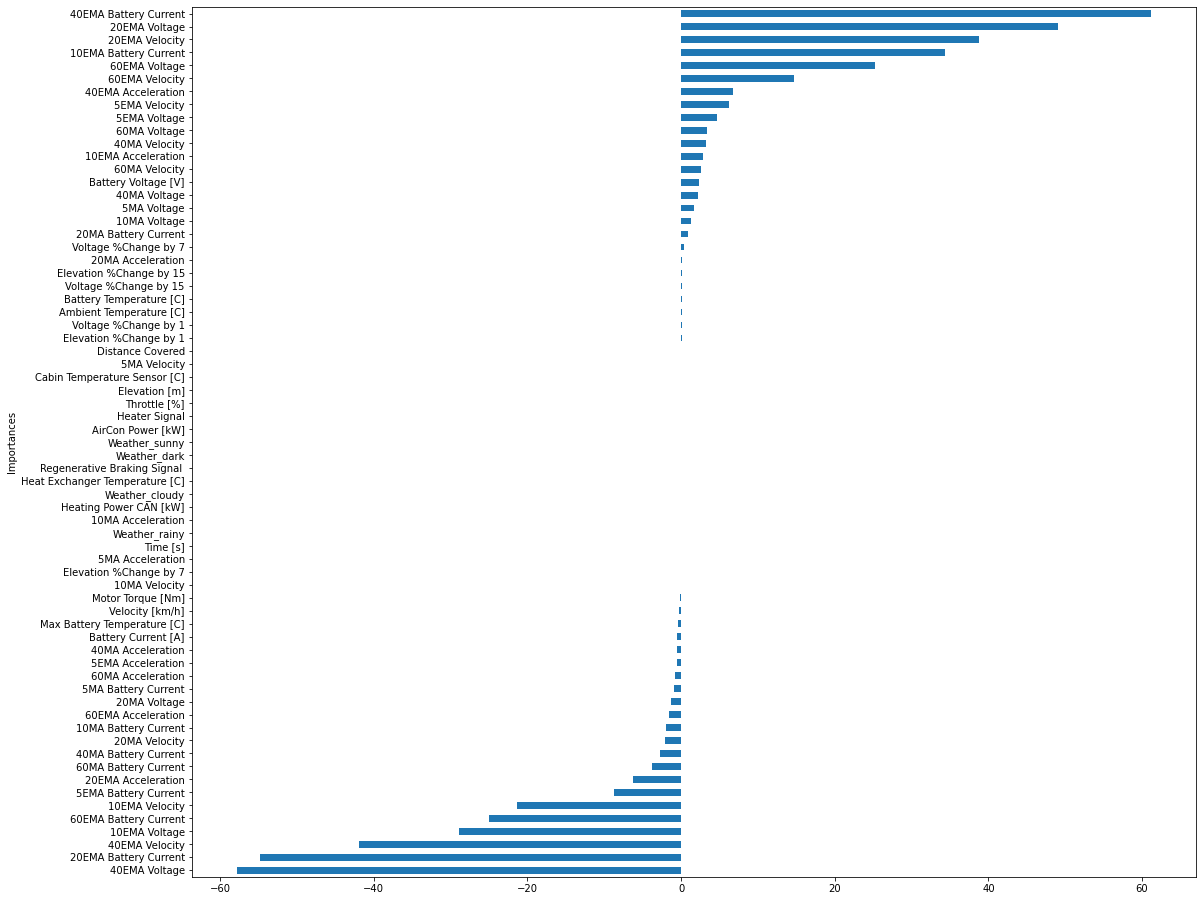

In [97]:
importances = model.coef_

linear_importance_df = pd.DataFrame({"feature": X_train.columns, "importance": importances})
linear_importance_df = linear_importance_df.sort_values("importance")

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.6f' % x):  # more options can be specified also
    print(linear_importance_df)

plt.rcParams["figure.figsize"] = (18,16)
    
ax = linear_importance_df.plot(kind = "barh", x="feature", legend = False)
ax.set_ylabel("Importances")

#### Decision Tree Feature Importance

In [98]:
model = RandomForestRegressor(n_estimators = 4, min_samples_split = 40, max_depth = 12)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_split=40, n_estimators=4)

                           feature  importance
56            Voltage %Change by 1    0.000000
31               5EMA Acceleration    0.000000
26                5MA Acceleration    0.000000
7              Battery Current [A]    0.000000
60           Voltage %Change by 15    0.000001
51            5EMA Battery Current    0.000001
4                Motor Torque [Nm]    0.000001
58            Voltage %Change by 7    0.000001
46             5MA Battery Current    0.000001
32              10EMA Acceleration    0.000001
16                     5MA Voltage    0.000002
17                    10MA Voltage    0.000002
52           10EMA Battery Current    0.000003
5     Regenerative Braking Signal     0.000006
28               20MA Acceleration    0.000007
53           20EMA Battery Current    0.000007
21                    5EMA Voltage    0.000007
48            20MA Battery Current    0.000008
6              Battery Voltage [V]    0.000010
47            10MA Battery Current    0.000010
33           

Text(0, 0.5, 'Importances')

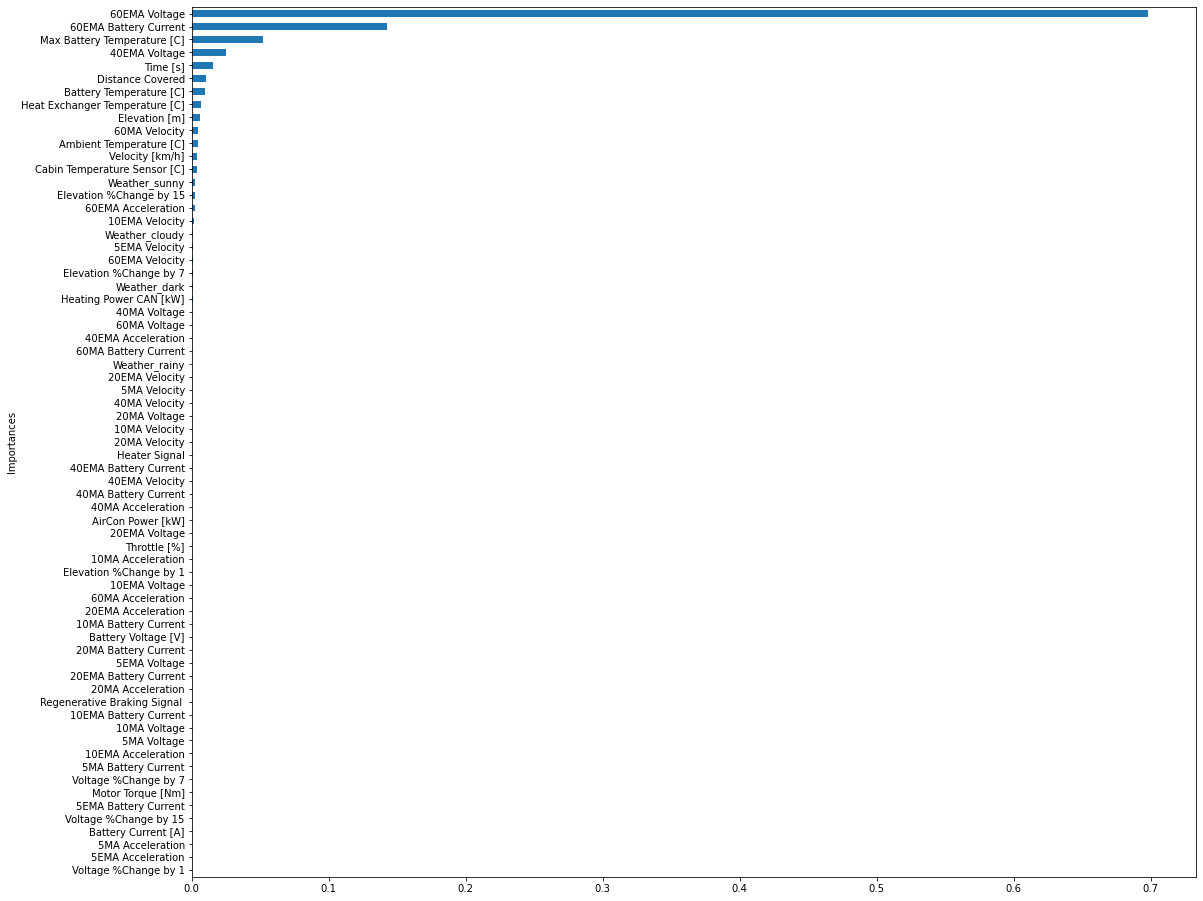

In [101]:
importances = model.feature_importances_

decision_importance_df = pd.DataFrame({"feature": X_train.columns, "importance": importances})
decision_importance_df = decision_importance_df.sort_values("importance")

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.6f' % x):  # more options can be specified also
    print(decision_importance_df)

ax = decision_importance_df.plot(kind = "barh", x="feature", legend = False)
ax.set_ylabel("Importances")

#### Feature Selection Logic

1) While we should consider both linear and decision trees, decision trees looked more effective for this scenario
2) We should select only the best performing MA or EMA in the categories Voltage, Acceleration, Velocity, and Current
3) Furthermore, select only the best performing elevation and voltage % changes
4) Finally, we should remove any low performing generated or non-generated features that performed lowly in both tests.
5) After discussion, we decided to keep certain features as well due to their importance and interaction with the dataset

#### Final Feature Selection

In [105]:
# Remove columns according to feature selection logic
norm_df = norm_df[["Time [s]",
                   "Velocity [km/h]",
                   "Motor Torque [Nm]",
                   "Battery Temperature [C]",
                   "Max Battery Temperature [C]",
                   "SoC [%]",
                   "Heating Power CAN [kW]",
                   "Ambient Temperature [C]",
                   "Heat Exchanger Temperature [C]",
                   "Cabin Temperature Sensor [C]",
                   "40MA Voltage",
                   "60EMA Voltage",
                   "60EMA Acceleration",
                   "60MA Velocity",
                   "10EMA Velocity",
                   "60EMA Battery Current",
                   "Elevation %Change by 15",
                   "Distance Covered",
                   "Weather_cloudy",
                   "Weather_dark",
                   "Weather_rainy",
                   "Weather_sunny"]]

### 8. Dataset Explorations after Selecting Features

Dataset statistics performed in Tableau as well as primary analysis

### 9. Predicting State of Charge (SoC) using Machine Learning

Section 9 was not performed as a part of the Master's Program as the dataset used to predict SoC changed into a single cell battery testing dataset, as per the program advisor's advice. This was to ensure that all electric vehicles were equally considered. However, in doing so we lose the dynamic aspects of our predictions such as weather, ambient temperature, and elevation changes. Please refer to the "Battery Dataset - Predictions" file for my contributions towards predictions made on the new battery dataset.